# Desafío Brain Food

Implementar un modelo que proyecte la demanda de productos agrícolas.


### Plan de Trabajo

*¿Cuál sería tu enfoque y plan de trabajo para abordar este desafío?*











Primero, es fundamental identificar y comprender el tipo de problema al que nos enfrentamos, en este caso, se trata de prever ventas. Segundo, reconocer y caracterizar el conjunto de datos con el que estamos trabajando.

El plan de trabajo considera lo anterior y los siguientes pasos:

- Comprender el Problema
- Caracterizar Dataset
- Análisis exploratorio
- Feature Engineer
- Modelo
- Optimizar Modelo
- Pronóstico


-----

*¿Qué tareas consideras esenciales para la ejecución de este proyecto?*

Considero fundamental una comprensión profunda del problema y conocer(caracterizar) el dataset.


----
*¿Qué elementos específicos desarrollarías para
resolver el problema planteado?*

1- Caracterizar Datasets

2- Análisis Explorario

3- Análisis de autocorrelación parcial: como afectan los valores previos(lags) .

4- Feature Engineer: Segmentar por producto, seleccionar variables, nuevas variables, etc.

5- Modelar: entrenamiento y prueba(testeo).

6- Medir desempeño del modelo.

7- Optimizar mediante hiperparámetros.

8- Proyectar.

9- Medir si la proyección tiene un retorno positivo.


-----
*Incluye una estimación del tiempo que dedicarías a cada fase y
explique cómo tu solución impactaría positivamente en la situación actual de la empresa.*

1- Dos hora

2- Dos hora

3- Media hora

4- Dos hora

5- Una hora

6- Media hora

7- Media hora

8- Una hora

9- Una hora


La solución reduciría los gastos de compra de productos en excesos acumulados en el inventario, por lo tanto,  el retorno positivo (ganacia mayor al costó) permitiría por ejemplo reinvertir en nuevos productos para la venta.

----





###Construcción del Modelo y Validación



1. *Construya un modelo que permita proyectar la demanda y explique las validaciones que aplicarías para determinar su eficacia. Además, indique la ventana de tiempo que seleccionarías para la proyección y justifica tu elección.*



- La ventana de proyección es de un mes, ya que las ventas tienen una autocorrelación significativa con las ventas de meses previos, en particular 3 meses anteriores para este problema.



2. *Generé un archivo CSV con las predicciones para el año 2024*

- En el jupyter notebook se implementa.


3. *Describa cómo funcionaría este modelo en un entorno productivo, con todo lo que esto implica.*

- Un entorno productivo implica una actualización de datos continua, y constante entrenamiento( reguido por la ventana de proyección y meses previos). Por tanto, primero sería la creación de DataWarehouse, dónde se almacen los datos de manera ordenada y adecuada para su posterior entrenamiento. Segundo, el modelado con reentrenamiento en cada ingreso de nuevos datos. Y tercero un monitoreo continuio del proceso. Todo lo anterior alojado en la nube que cumpla con criterios anteriores y el presupuesto destinado para este propósito.




#Resumen

*Se implementó un modelo LightGBM a los productos con datos historicos con al menos 66 instancias, utlizando rezagos. proyectando mediante Multistep a 12 meses desde su última venta. Se aplicó regularizacion L2, pero una cierta categoría de productos muestran indicios aún de overfitting.*

### Caracterizar Dataset

- Número de instancias: **80748**.
- Número de caracteristicas: **4**.
- Valores Nulos: **0**.

- Cantidad de Productos comercializados por la empresa: **1000**

### Funciones

**descomposicion_ventas**

input: ( Dataframe, share_type, samples, period )

output: None


 Función que descompone  la serie temporal en: lo observado, la tendencia, la estacionalidad y el ruido. Mostrando la descomposición en una gráfica.


**segmentar**

input: Dataframe

output: Diccionario

Devuelve un dictionario con los producto segmentados y sus respectivos datos historicos


**procesar**

input: (Dataframe , Lags)

output: Diccionario

Función que segmenta y aplica rezagos(lags).

**encoder**

input: Dataframe

output: Dataframe

Codifica los meses del año con `OneHotEncoder()`.


**modelo_lgb**

input: (Dataframe , número de instancias, Lags )

output: (Diccionario con las proyecciones , Diccionario con las métricas)

Función que usa lightGBM (entrenar y testear), para luego realizar una proyección de 12 meses.

**proyecciones**

input: (Diccionario con las proyecciones, Diccionario con las métricas, Diccionario procesado, Entero que identica el producto ID)

output:None

Muestra el gráfico de la serie temporal historica con los valores proyectados del producto ID ingresado. Además de informar los valores de la métrica



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings

%matplotlib inline

from scipy.signal import periodogram
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import OneHotEncoder

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import  mean_squared_log_error as msle

warnings.filterwarnings("ignore", message="Usage of np.ndarray subset (sliced data) is not recommended")


# Análisis Exploratorio



In [ ]:
demanda = pd.read_csv('/content/desafio_modelo_de_demanda.csv', index_col=['fecha'],
                      parse_dates=['fecha'], infer_datetime_format=True ) # index en tipo datetime
df = demanda.copy() #copia para evitar modificaciones en los datos fuentes
df.head()


,prod_id,precio_promedio,ventas,modelo_actual
fecha,,,,
2017-01-01,0,6651.737920,1786.0,1943.551087
2017-02-01,0,4919.698602,2194.0,1853.111850
2017-03-01,0,3277.484704,1178.0,1659.733052
2017-04-01,0,5906.864332,1010.0,1580.492875
2017-05-01,0,4662.644018,1327.0,1552.062093


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80748 entries, 2017-01-01 to 2019-12-01
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   prod_id          80748 non-null  int64  
 1   precio_promedio  80748 non-null  float64
 2   ventas           80748 non-null  float64
 3   modelo_actual    80748 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 3.1 MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
prod_id,80748.0,498.788379,290.397741,0.000000,248.000000,494.000000,751.000000,999.000000
precio_promedio,80748.0,5386.770862,2893.919808,606.335817,3018.438689,5079.052675,7336.782635,13978.011657
ventas,80748.0,1089.565958,716.509618,0.000000,547.000000,954.000000,1468.000000,6404.000000
modelo_actual,80748.0,1093.682259,507.905494,0.000000,713.346179,1064.464617,1421.259490,5397.308408


 La tabla descriptiva  muestra que el promedio de ventas proyectadas `modelo_actual` supera el promedio de ventas realizadas `ventas`. En general, si es el único proveedor, debe ocurrir que:

`modelo_actual` $\geq$ `ventas`.  




In [ ]:
# cuantos tipos de productos se comercializan
print('Cantidad de Tipos de producto : ',  df['prod_id'].unique().size )


Cantidad de Tipos de producto :  1000


## Análisis General




### Comparacion de las ventas realizadas y las ventas proyectadas.

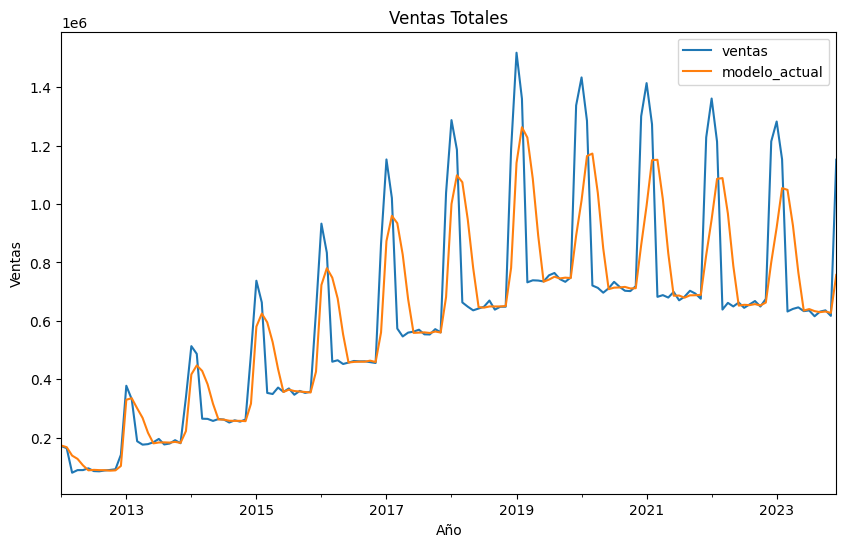

In [ ]:
# agrupa por primer dia de cada mes luego suma el total de ventas.
agrupa_por_fechas = df.groupby('fecha')


# Plot  Ventas Totales
agrupa_por_fechas.sum()[['ventas', 'modelo_actual', ]   ].plot(figsize=(10, 6), title='Ventas Totales')
plt.xlabel('Año')
plt.ylabel('Ventas')
plt.show()

### Precio

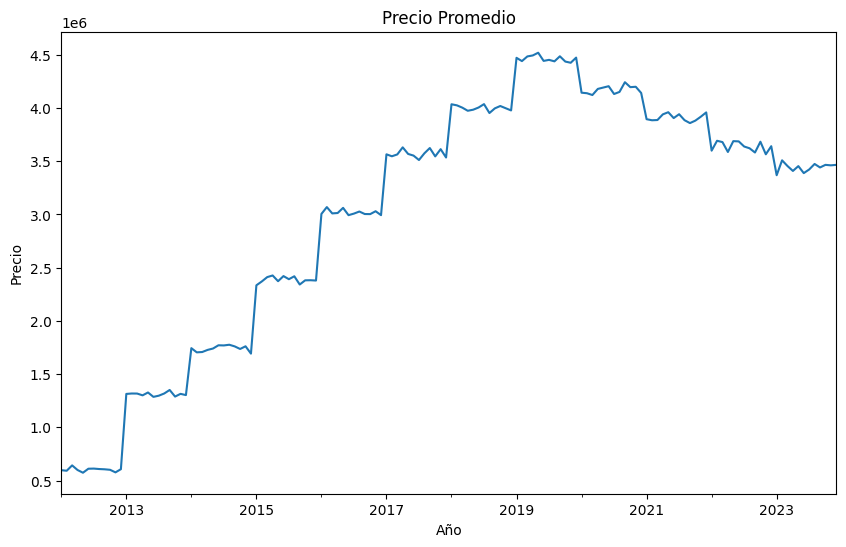

In [ ]:
# Plot  Ventas Totales
agrupa_por_fechas['precio_promedio'].sum().plot(figsize=(10, 6), title='Precio Promedio')
plt.xlabel('Año')
plt.ylabel('Precio')
plt.show()

Nos muestra que desde 2013 hay una tendencia al alza, con periodicidad anual, Ya a fin del 2019 -inicio de covid- ocurre una baja en ventas (sin una periodicidad clara como en la alza).mientras que en los últimos años existe una cierta estabilidad fluctuado entorno a valor.

### Correlación

<Axes: >

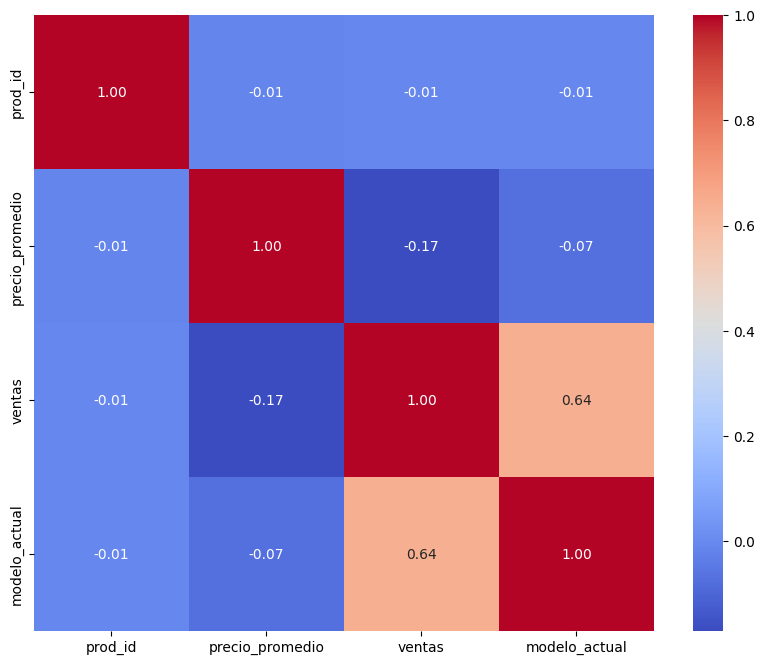

In [ ]:
matriz_corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f")


### Descomposición  Ventas


In [ ]:
def descomposicion_ventas(df, share_type='ventas', samples=250, period=30):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)

    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid

    #plot Serie de Tiempo completa
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVADO', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()

    #plot Tendencia de la Serie de Tiempo
    axs[1].set_title('TENDENCIA', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()

    #plot Estacionalidad dado un periodo.
    axs[2].set_title('ESTACIONALIDAD', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()

    #plot El ruido de la Serie de Tiempo
    axs[3].set_title('RUIDO', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()

    plt.show()

Descomposición de las ventas  en un rango de un año, con período de un mes.

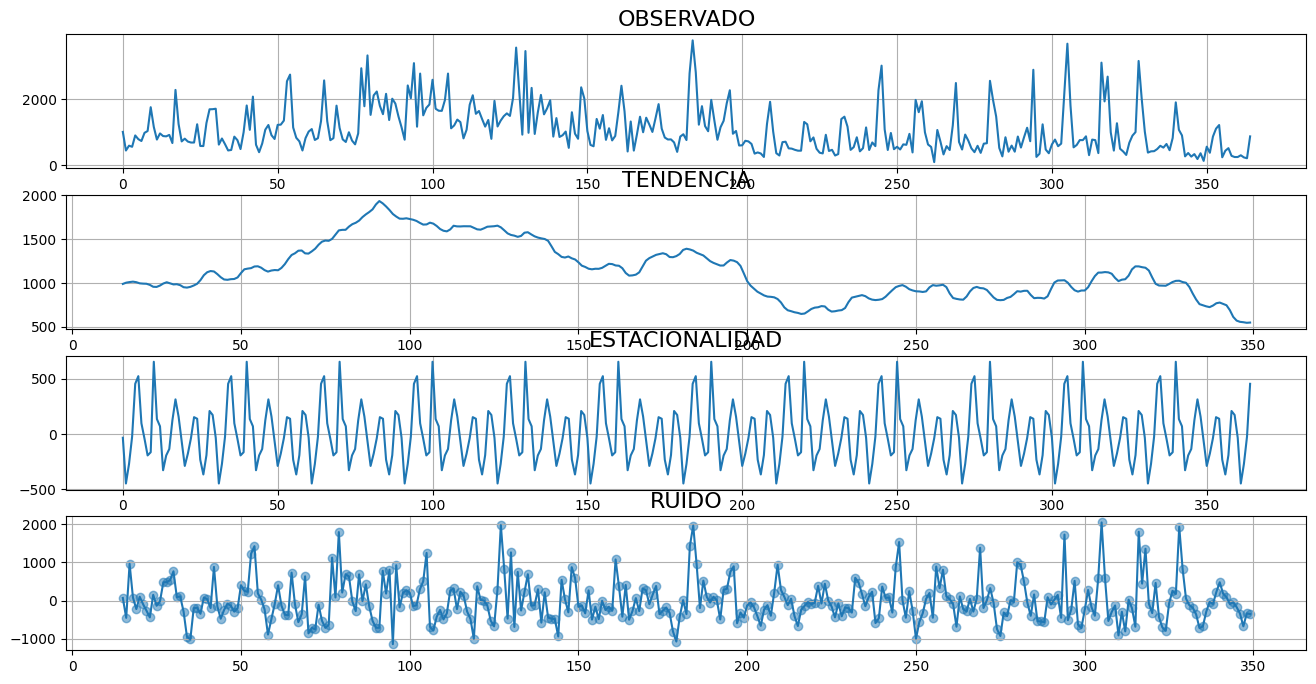

In [ ]:
descomposicion_ventas( df, samples= 365, period = 30 )


Comportamiento de las ventas proyectas en un año (Modelo defectuoso).

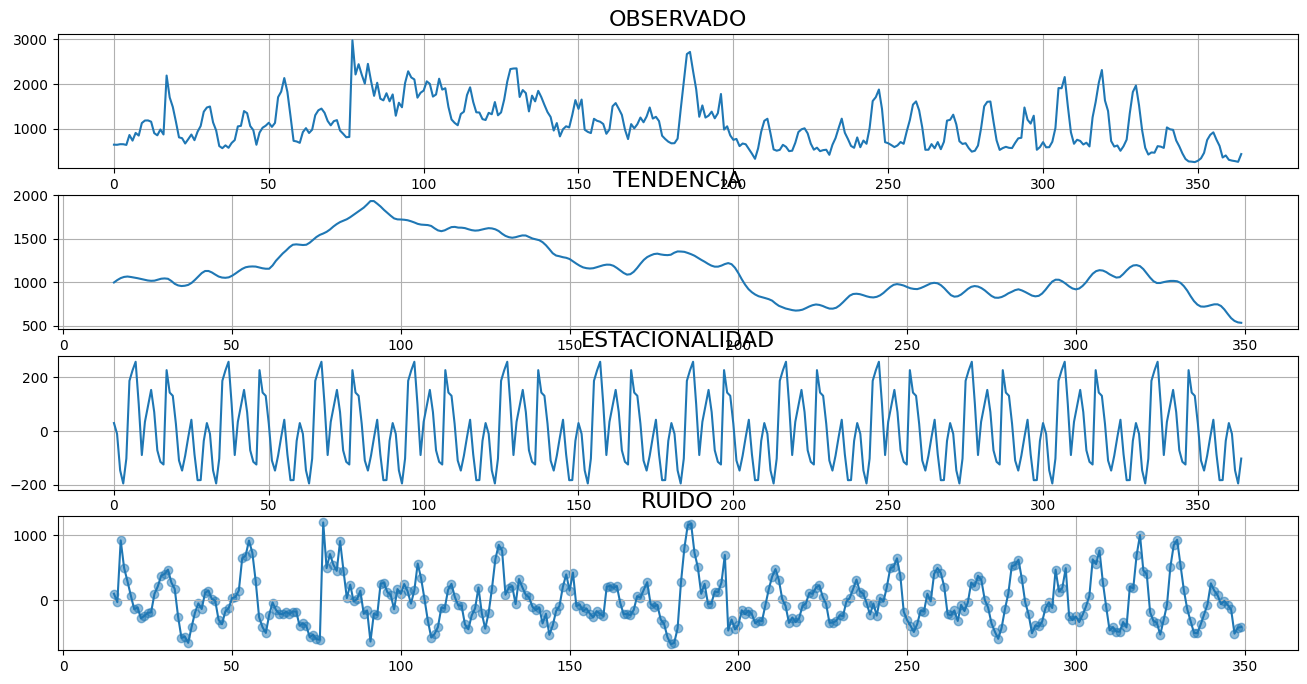

In [ ]:
descomposicion_ventas( df, share_type='modelo_actual', samples= 365, period = 30 )


Se evidencia una discrepancia en la estacionalidad (seasonality), es decir durante el período de un mes.  

### Autocorrelación Parcial

Revisamos comó se correlaciona las ventas con las ventas en meses anteriores.

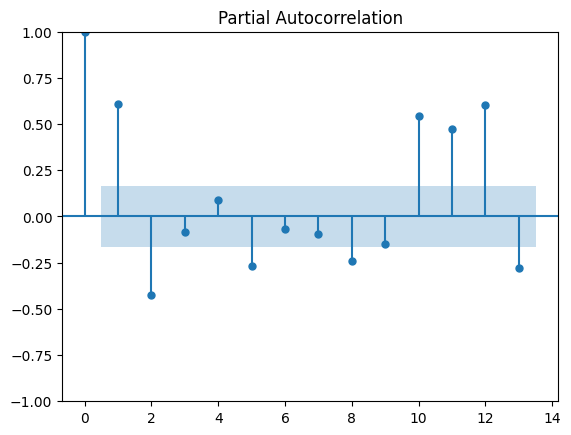

In [ ]:

df_medias = (
    df
    .groupby('fecha').mean()
    .squeeze()
    .loc['2012':]
)


_ = plot_pacf( df_medias['ventas'] , lags=13)



Nos indica que los dos meses anteriores y las ventas alrededor de un año ( mes 10,11,12,13 )  atrás  son significativos.

## Featured Engineer





### Fourier ( candidato a salir)

In [ ]:
df.drop('modelo_actual', axis=1, inplace=True)
df.drop('precio_promedio', axis=1, inplace=True)

In [ ]:
y = df.to_period('D')

fourier = CalendarFourier(freq='M', order=4)


In [ ]:
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,

)

X = dp.in_sample()



### Segmentación de los Productos.

In [ ]:
# Segmentar los datos por producto

def segmentar(df):
  productos = df['prod_id'].unique()

  datos_por_producto = {}

  # Iterar sobre cada producto y almacenar los datos correspondientes en el diccionario
  for producto in productos:
      datos_producto = df[df['prod_id'] == producto]
      datos_por_producto[producto] = datos_producto

  return datos_por_producto




In [ ]:

# Mostrar los datos de un producto específico (por ejemplo, el producto 0)
print("Datos del producto 0:")
print( segmentar(df)[0])

Datos del producto 0:
            prod_id  ventas
fecha                      
2017-01-01        0  1786.0
2017-02-01        0  2194.0
2017-03-01        0  1178.0
2017-04-01        0  1010.0
2017-05-01        0  1327.0
...             ...     ...
2023-08-01        0  1338.0
2023-09-01        0   935.0
2023-10-01        0  1347.0
2023-11-01        0   762.0
2023-12-01        0  2252.0

[84 rows x 2 columns]


### Lags sobre cada producto.

In [ ]:
def procesar(df , lags = [1, 2, 3]):
    segmentados = segmentar(df)
    for producto, datos_producto in segmentados.items():
        # lags a implementar
        for k in lags: # 11, 12, 13]:
          datos_producto = datos_producto.copy()  # Crear una copia explícita de los datos del producto
          datos_producto[f'lag_{k}'] = datos_producto.loc[: , 'ventas' ].shift(k)
          datos_producto.dropna( axis=0 ,  inplace=True )
          segmentados[producto] = datos_producto
    return segmentados


In [ ]:
# Procesados datos Historicos
datos_historicos = procesar(df)

In [ ]:
def encoder(df):
  # Extract Month as a feature
  df["month_feature"] = df.index.month

  # One-hot encoder the month feature
  encoder = OneHotEncoder(sparse_output=False)#,drop="first")
  month_encoded = encoder.fit_transform(df[['month_feature']])
  month_encoded_df = pd.DataFrame(month_encoded, index=df.index, columns=[f'month_{i+1}' for i in range(month_encoded.shape[1]  )])

  # Join the encoded features with the original dataframe
  df = pd.concat([df, month_encoded_df], axis=1)

  return df

In [ ]:
# Modelo LightGBM
# Los modelos de pronóstico basados en árboles de decisión no son eficases captando la tendencia, para mejorar aquello es esencial
# configurar el parametro: "linear_tree: True".


def modelo_lgb(df,  num_instancias=66, lags=[1,2,3,12]):
  df = encoder(df)
  dataset = procesar(df, lags)

  features =  [f'lag_{i}' for i in  lags ] +[f'month_{i+1}' for i in range(12)]

  # Configure and train the LightGBM model
  params = {
      'objective': 'regression',
      'metric': 'rmse',
      'lambda_l2': 0.5,
      'metric': 'rmse',
      'linear_tree': True,
      'num_leaves': 10,
      'learning_rate': 0.005,
      'feature_fraction': 0.9,
       'min_data_in_leaf': 5,
      'verbose':-1
  }

  proyeccion = {}
  metricas = {}

  for producto, datos in dataset.items():
    if len(datos) < num_instancias :
      continue

    # Datos de entrenamiento son el 80% de los datos historicos, el resto para testeo
    train_size = int( 0.8*len( datos ) )
    train = datos[:train_size]
    test = datos[train_size:]

    X_train, y_train = train[features], train['ventas']
    X_test, y_test = test[features], test['ventas']

    train_data = lgb.Dataset(X_train, label=y_train)

    gbm = lgb.train(params, train_data, num_boost_round=200)

    y_pred_train = gbm.predict(X_train)
    y_pred = gbm.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

    # Proyecciones

    forecasting = []
    datos = datos[features].values
    for month in range(1,13):
      input_features = datos[-1].reshape(1, -1)

      # Make forecast for the current month
      forecast = gbm.predict(input_features)[0]
      forecasting.append(forecast)

      # Update lagged features for the next month
      datos = np.roll(datos, -1, axis=0)
      datos[-1] = np.concatenate(([forecast], datos[-1, :-13], [ 1 if month==j else 0 for j in range(1,13)  ] ))

    metricas[producto] = [ len(datos), rmse_train, rmse_test]
    proyeccion[producto] = forecasting

  return proyeccion, metricas


In [ ]:
warnings.filterwarnings("ignore", module="lightgbm.basic")

forecasting , metrica = modelo_lgb(df, num_instancias=18, lags=[1, 2,3, 12] )

In [ ]:
def proyecciones(  forecasting, metrica,datos_historicos=None, producto=0):
  if datos_historicos == None:
    print("Ingrese los datos historicos")

  if producto not in forecasting.keys():
    print("Producto con datos historicos insuficientes para proyectar ventas")
    return None

  ventas = datos_historicos[producto]['ventas']

  index_2024 = pd.date_range( start= ventas.index[-1], periods=13, freq="MS")

  data_proyectada = pd.DataFrame( [ventas[-1]] + forecasting[producto], index = index_2024 , columns=["Ventas_2024"])


  figure, ax = plt.subplots(figsize=(12, 5))
  ventas.plot(ax=ax, label="Datos Historicos" )
  data_proyectada.plot(ax=ax, label="Testing",)
  plt.show()

  print( ' RMSE Train:', metrica[producto][1], "\n",'RMSE Test: ', metrica[producto][2])

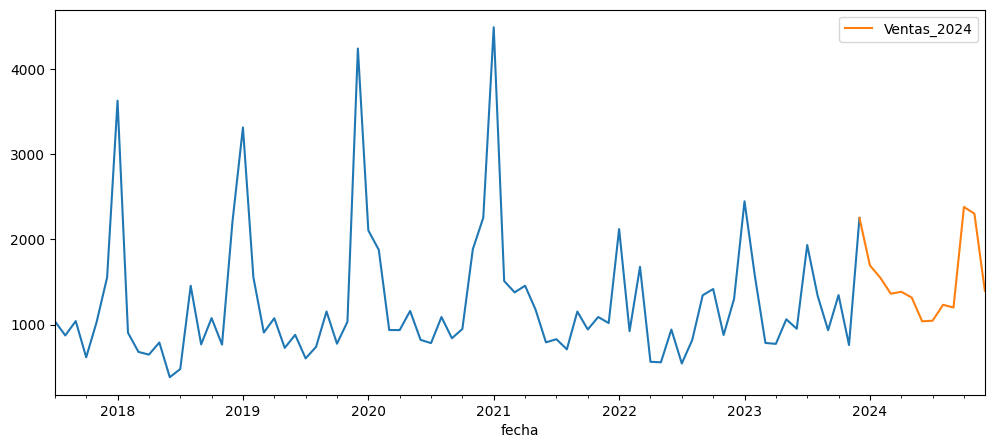

 RMSE Train: 484.1766431572895 
 RMSE Test:  440.04987576056794


In [ ]:
proyecciones( forecasting, metrica, datos_historicos, producto=0 )